In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
from sklearn import cross_validation, metrics
from patsy import dmatrices
import sklearn
import statsmodels.api as sm
from random import shuffle



pd.options.mode.chained_assignment = None 
%matplotlib inline

In [132]:
columns = ['title', 'opening_date', 'ratings', 'month_released', 'opening_weekend', 'day_released', 'runtime_minutes',
          'gross', 'budget', 'usa_dummy', 'genre']
final_df = pd.read_pickle('movies_travis_df_clean.pkl')
final_df.columns = columns

In [133]:
final_df.head()

,title,opening_date,ratings,month_released,opening_weekend,day_released,runtime_minutes,gross,budget,usa_dummy,genre
0,Boyhood,2014-08-15 00:00:00,100,August,387618,Friday,165,25359200,4000000,1,Drama
3,12 Years a Slave,2013-11-08 00:00:00,100,November,923715,Friday,134,56667870,20000000,1,Biography
4,Ratatouille,2007-06-29 00:00:00,88,June,47027395,Friday,111,206435493,150000000,1,Animation
5,Gravity,2013-10-04 00:00:00,100,October,55785112,Friday,91,274084951,100000000,0,Adventure
6,Carol,2016-01-15 00:00:00,100,January,253510,Friday,118,253510,11800000,0,Drama


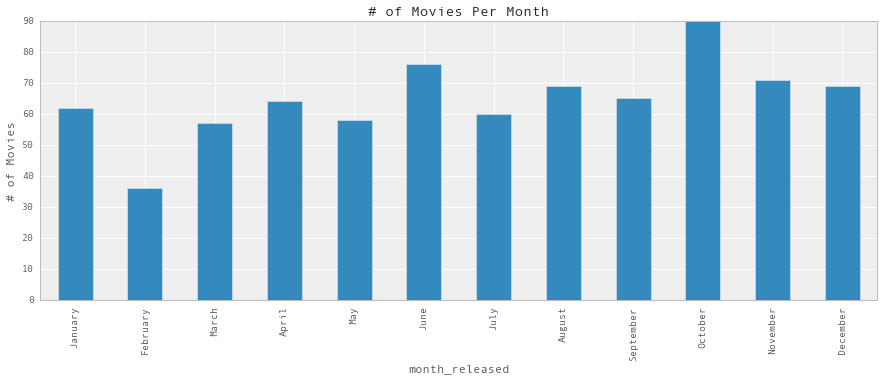

In [134]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October',
          'November', 'December']

figure = plt.figure()
titles_per_month = final_df.groupby('month_released').count().title[months]
titles_per_month.plot('bar')
figure.set_size_inches(15,5)
plt.ylabel('# of Movies')
_ = plt.title('# of Movies Per Month')

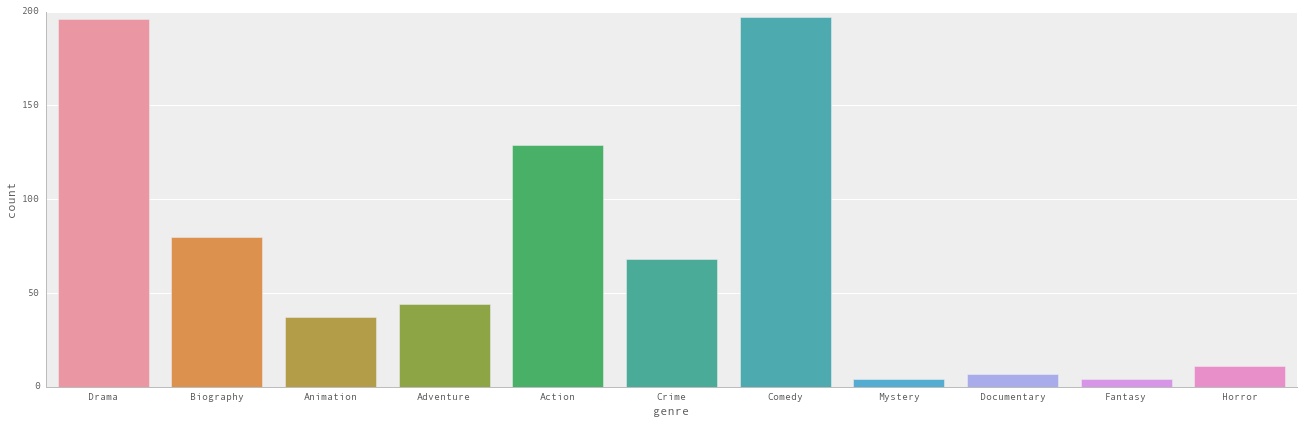

In [135]:
_ = sns.factorplot(x = 'genre', data = final_df, kind = 'count', size = 6, aspect = 3 )

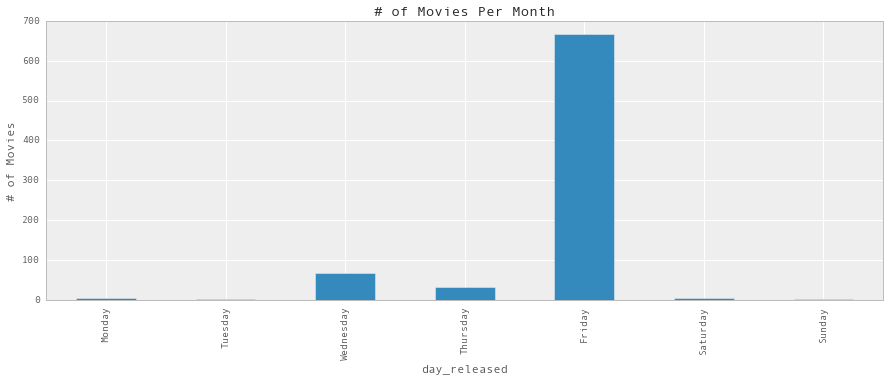

In [172]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

figure = plt.figure()
titles_per_month = final_df.groupby('day_released').count().title[days]
titles_per_month.plot('bar')
figure.set_size_inches(15,5)
plt.ylabel('# of Movies')
_ = plt.title('# of Movies Per Month')

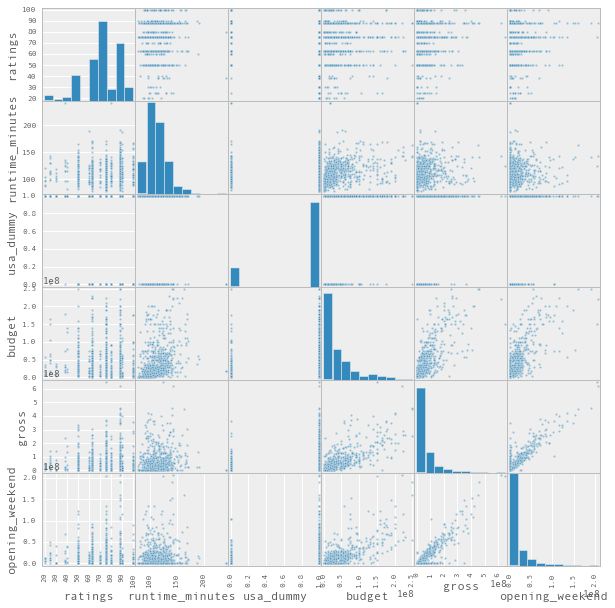

In [138]:
columns = ['ratings', 'runtime_minutes', 'usa_dummy', 'budget', 'gross', 'opening_weekend']
pd.set_option('display.mpl_style', 'default')              
plt.rcParams['figure.figsize'] = (10, 10)
_ = pd.tools.plotting.scatter_matrix(final_df[columns])

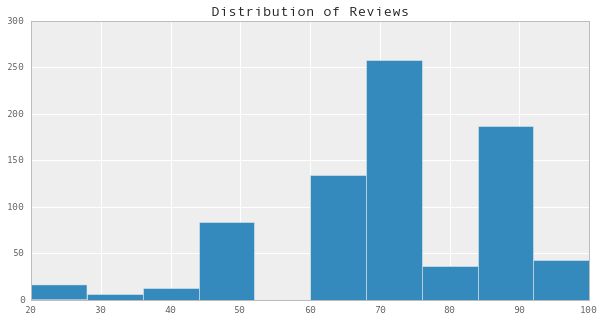

In [140]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.hist(x = final_df.ratings)
_ = plt.title('Distribution of Reviews')

In [141]:
# Skewed!

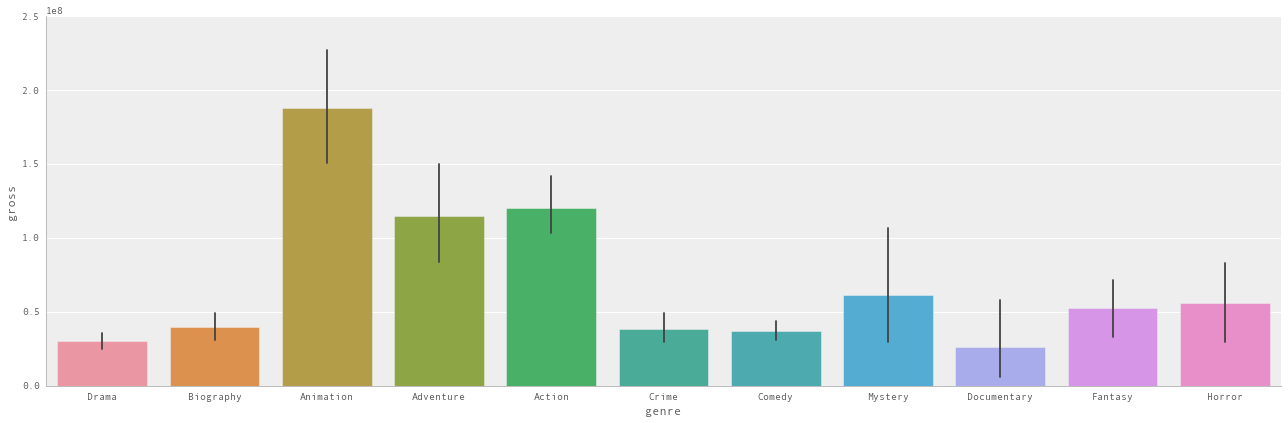

In [142]:
_ = sns.factorplot(x = 'genre', y = 'gross', data = final_df,  kind = 'bar', size = 6, aspect = 3)

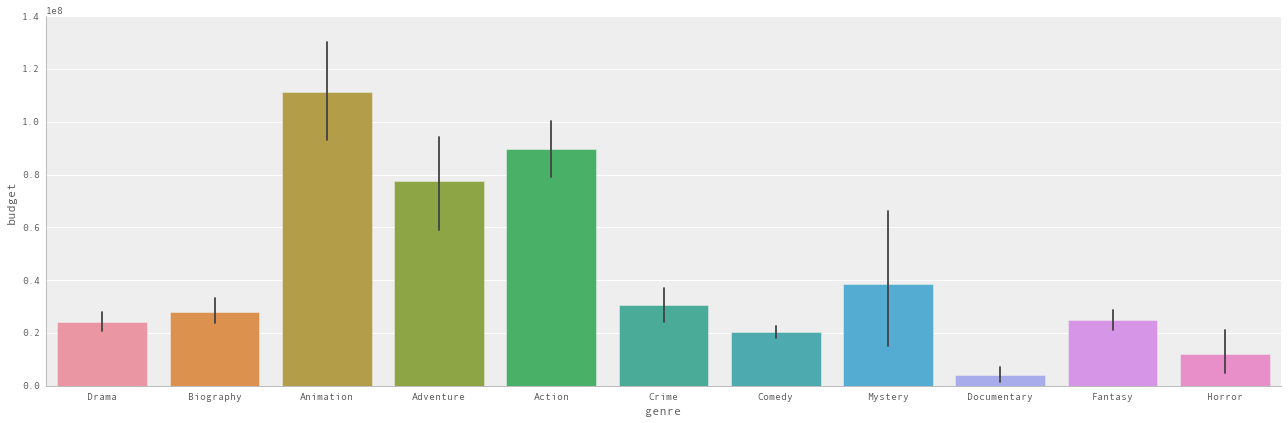

In [143]:
_ = sns.factorplot(x = 'genre', y = 'budget', data = final_df,  kind = 'bar', size = 6, aspect = 3)

# Prediction

In [144]:
# Transform Skewed Labels
final_df['log_ratings'] = np.log(final_df.ratings)


newM, lmbdaM = sp.stats.boxcox(final_df['ratings'])
newM = list(newM)
final_df['box_cox_ratings'] = newM

In [167]:
log_baseline = sum((log_y.values-log_y.values.mean())**2)/len(log_y)
print 'Baseline: %r' %log_baseline[0]

Baseline 0.073889197102039422


In [147]:
y, X = dmatrices('ratings ~ day_released + runtime_minutes + budget + usa_dummy + genre + month_released', data=final_df, return_type='dataframe')
log_y, log_X = dmatrices('log_ratings ~ day_released + runtime_minutes + budget + usa_dummy + genre + month_released', data=final_df, return_type='dataframe')
box_cox_y, box_cox_X = dmatrices('box_cox_ratings ~ day_released + runtime_minutes + budget + usa_dummy + genre + month_released', data=final_df, return_type='dataframe')


X_train, X_test, y_train, y_test = cross_validation.train_test_split(log_X, log_y, test_size=0.20, random_state=14)
log_X_train, log_X_test, log_y_train, log_y_test = cross_validation.train_test_split(log_X, log_y, test_size=0.20, random_state=15)
box_cox_X_train, box_cox_X_test, box_cox_y_train, box_cox_y_test = cross_validation.train_test_split(box_cox_X, box_cox_y, test_size=0.20, random_state=16)

In [816]:
no_dummy_column = ['usa_dummy','new_budget','runtime_in_minutes']

## No Transformation

In [156]:
org_baseline = sum((y.values-y.values.mean())**2)/len(y)
print org_baseline

[ 261.83781134]


In [157]:
from sklearn import linear_model

In [161]:
reg = linear_model.LinearRegression()

reg.fit(X_train, y_train)

training_error = (sklearn.metrics.mean_squared_error(y_train, reg.predict(X_train)))
print 'Training Error: %r' %training_error
test_error = (sklearn.metrics.mean_squared_error(y_test, reg.predict(X_test)))
print 'Test Error: %r' %test_error

print 'Gain: %r' %((org_baseline - test_error)/org_baseline)[0]

Training Error: 0.069102141406237869
Test Error: 0.072089513904735225
Gain: 0.99972467874850868


In [168]:
org_model_lasso = sklearn.linear_model.LassoCV(eps=0.001, n_alphas=100, cv=10).fit(X_train, sklearn.utils.column_or_1d(y_train))

training_error = (sklearn.metrics.mean_squared_error(y_train, org_model_lasso.predict(X_train)))
print 'Training Error: %r' %training_error
test_error = (sklearn.metrics.mean_squared_error(y_test, org_model_lasso.predict(X_test)))
print 'Test Error: %r' %test_error

print('alpha=', org_model_lasso.alpha_)
print 'Gain: %r' %((org_baseline - test_error)/org_baseline)[0]

Training Error: 0.073717445636688403
Test Error: 0.073275742066136185
('alpha=', 12814.246435649755)
Gain: 0.99972014835560885


In [170]:
#Ridge

org_model_ridge = sklearn.linear_model.RidgeCV( cv=10).fit(X_train, sklearn.utils.column_or_1d(y_train))

training_error = (sklearn.metrics.mean_squared_error(y_train, org_model_ridge.predict(X_train)))
print 'Training Error %r'%training_error
test_error = (sklearn.metrics.mean_squared_error(y_test, org_model_ridge.predict(X_test)))
print 'Test Error: %r' %test_error

print('alpha=', org_model_ridge.alpha_)
print 'Gain: %r' %((org_baseline - test_error)/org_baseline)[0]
# m_alphas = org_model_lasso.alphas_



Training Error 0.069888696611993387
Test Error: 0.071035098725374612
('alpha=', 10.0)
Gain: 0.99972870572678962


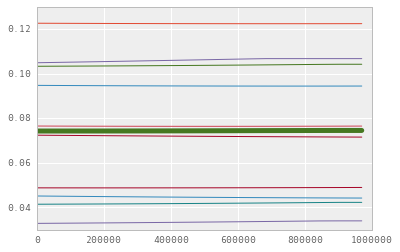

In [173]:
plt.plot(org_model_lasso.alphas_, org_model_lasso.mse_path_);
plt.plot(org_model_lasso.alphas_, org_model_lasso.mse_path_.mean(1), lw=5)


In [177]:
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ratings   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.980
Date:                Mon, 19 Sep 2016   Prob (F-statistic):            0.00151
Time:                        20:53:56   Log-Likelihood:                -3235.8
No. Observations:                 777   AIC:                             6534.
Df Residuals:                     746   BIC:                             6678.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                      68.2881      4.841     14.105      0.000        58.784    77.793
day_released[T.Monday]          1.4395      8.166      0.176      0.860       -14.591    17.470
day_released[T.Saturday]       -2.3695      7.382     -0.321      0.748       -16.861    12.122
day_released[T.Sunday]          9.5689     11.396      0.840      0.401       -12.802    31.940
day_released[T.Thursday]       -1.7622      3.014     -0.585      0.559        -7.679     4.155
day_released[T.Tuesday]        -5.2204     16.243     -0.321      0.748       -37.108    26.667
day_released[T.Wednesday]      -1.8375      2.131     -0.862      0.389        -6.020     2.345
genre[T.Adventure]              8.9215      2.860      3.119      0.002         3.307    14.536
genre[T.Animation]              8.2824      3.189      2.597      0.010         2.023    14.542
genre[T.Biography]              7.5631      2.617      2.890      0.004         2.425    12.701
genre[T.Comedy]                 2.1098      2.147      0.983      0.326        -2.105     6.325
genre[T.Crime]                  5.3566      2.621      2.044      0.041         0.211    10.502
genre[T.Documentary]           12.2502      6.473      1.892      0.059        -0.457    24.958
genre[T.Drama]                  3.6637      2.151      1.703      0.089        -0.559     7.886
genre[T.Fantasy]               -2.7586      8.166     -0.338      0.736       -18.789    13.272
genre[T.Horror]                -1.8701      5.221     -0.358      0.720       -12.119     8.379
genre[T.Mystery]               16.7869      8.189      2.050      0.041         0.711    32.863
month_released[T.August]       -0.1111      2.811     -0.040      0.968        -5.630     5.408
month_released[T.December]     -2.5797      2.981     -0.865      0.387        -8.431     3.272
month_released[T.February]     -4.2142      3.382     -1.246      0.213       -10.853     2.425
month_released[T.January]       3.4003      2.911      1.168      0.243        -2.314     9.114
month_released[T.July]          0.9085      2.952      0.308      0.758        -4.888     6.705
month_released[T.June]         -0.9718      2.771     -0.351      0.726        -6.411     4.467
month_released[T.March]        -4.6226      2.950     -1.567      0.118       -10.413     1.168
month_released[T.May]          -4.8968      2.973     -1.647      0.100       -10.734     0.940
month_released[T.November]     -0.2138      2.838     -0.075      0.940        -5.786     5.358
month_released[T.October]      -5.0409      2.659     -1.896      0.058       -10.261     0.179
month_released[T.September]    -5.5691      2.849     -1.955      0.051       -11.163     0.024
runtime_minutes                 0.0424      0.037      1.153      0.249        -0.030     0.115
budget     

## Log Transform

In [179]:
#Baseline
log_baseline = sum((log_y.values-log_y.values.mean())**2)/len(log_y)

In [180]:
reg = linear_model.LinearRegression()

reg.fit(log_X_train, log_y_train)

training_error = (sklearn.metrics.mean_squared_error(log_y_train, reg.predict(log_X_train)))
print 'Training Error: %r' %training_error
test_error = (sklearn.metrics.mean_squared_error(log_y_test, reg.predict(log_X_test)))
print 'Test Error: %r' %test_error
print 'Gain: %r' %((log_baseline - test_error)/log_baseline)[0]

Training Error: 0.06874770847130314
Test Error: 0.073741997935286685
Gain: 0.0019921608641850354


In [181]:
#Lasso

log_model_lasso = sklearn.linear_model.LassoCV(eps=0.001, n_alphas=100, cv=10).fit(log_X_train, sklearn.utils.column_or_1d(log_y_train))

#model_lasso1.predict(x_test,y_test)
training_error = (sklearn.metrics.mean_squared_error(log_y_train, log_model_lasso.predict(log_X_train)))
print 'Training Error: %r' %training_error
test_error = (sklearn.metrics.mean_squared_error(log_y_test, log_model_lasso.predict(log_X_test)))
print 'Test Error: %r' %test_error
print('alpha=', log_model_lasso.alpha_)
print 'Gain: %r' %((log_baseline - test_error)/log_baseline)[0]

Training Error: 0.073243133135209429
Test Error: 0.075192258998200603
('alpha=', 893.83092650987169)
Gain: -0.017635350596132207


In [182]:
#Ridge

log_model_ridge = sklearn.linear_model.RidgeCV(cv=10).fit(log_X_train, sklearn.utils.column_or_1d(log_y_train))

#model_lasso1.predict(x_test,y_test)
training_error = (sklearn.metrics.mean_squared_error(log_y_train, log_model_ridge.predict(log_X_train)))
print 'Training Error: %r' %training_error
test_error = (sklearn.metrics.mean_squared_error(log_y_test, log_model_ridge.predict(log_X_test)))
print 'Test Error: %r' %test_error
print('alpha=', log_model_ridge.alpha_)
print 'Gain: %r' %((log_baseline - test_error)/log_baseline)[0]

Training Error: 0.069546633479308326
Test Error: 0.072370584307050401
('alpha=', 10.0)
Gain: 0.020552568637223777


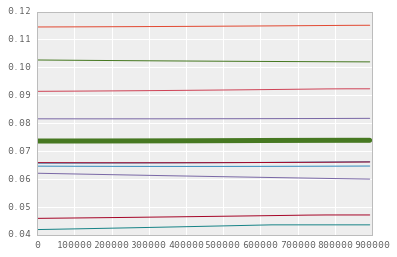

In [183]:
plt.plot(log_model_lasso.alphas_, log_model_lasso.mse_path_);
plt.plot(log_model_lasso.alphas_, log_model_lasso.mse_path_.mean(1), lw=5)

In [184]:
model = sm.OLS(log_y, log_X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_ratings   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.712
Date:                Mon, 19 Sep 2016   Prob (F-statistic):             0.0107
Time:                        20:54:23   Log-Likelihood:                -64.527
No. Observations:                 777   AIC:                             191.1
Df Residuals:                     746   BIC:                             335.4
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                       4.2221      0.082     51.654      0.000         4.062     4.383
day_released[T.Monday]          0.0210      0.138      0.153      0.879        -0.250     0.292
day_released[T.Saturday]       -0.0276      0.125     -0.221      0.825        -0.272     0.217
day_released[T.Sunday]          0.1763      0.192      0.916      0.360        -0.201     0.554
day_released[T.Thursday]       -0.0199      0.051     -0.392      0.695        -0.120     0.080
day_released[T.Tuesday]        -0.0600      0.274     -0.219      0.827        -0.598     0.478
day_released[T.Wednesday]      -0.0252      0.036     -0.702      0.483        -0.096     0.045
genre[T.Adventure]              0.1365      0.048      2.827      0.005         0.042     0.231
genre[T.Animation]              0.1172      0.054      2.177      0.030         0.012     0.223
genre[T.Biography]              0.1209      0.044      2.735      0.006         0.034     0.208
genre[T.Comedy]                 0.0356      0.036      0.982      0.327        -0.036     0.107
genre[T.Crime]                  0.0887      0.044      2.005      0.045         0.002     0.176
genre[T.Documentary]            0.1844      0.109      1.687      0.092        -0.030     0.399
genre[T.Drama]                  0.0429      0.036      1.180      0.238        -0.028     0.114
genre[T.Fantasy]               -0.0307      0.138     -0.223      0.824        -0.301     0.240
genre[T.Horror]                -0.0508      0.088     -0.576      0.565        -0.224     0.122
genre[T.Mystery]                0.2479      0.138      1.793      0.073        -0.024     0.519
month_released[T.August]       -0.0023      0.047     -0.047      0.962        -0.095     0.091
month_released[T.December]     -0.0416      0.050     -0.828      0.408        -0.140     0.057
month_released[T.February]     -0.0714      0.057     -1.251      0.211        -0.184     0.041
month_released[T.January]       0.0447      0.049      0.910      0.363        -0.052     0.141
month_released[T.July]          0.0225      0.050      0.451      0.652        -0.075     0.120
month_released[T.June]         -0.0349      0.047     -0.746      0.456        -0.127     0.057
month_released[T.March]        -0.0749      0.050     -1.504      0.133        -0.173     0.023
month_released[T.May]          -0.0930      0.050     -1.852      0.064        -0.192     0.006
month_released[T.November]     -0.0116      0.048     -0.242      0.809        -0.106     0.082
month_released[T.October]      -0.0837      0.045     -1.863      0.063        -0.172     0.004
month_released[T.September]    -0.0891      0.048     -1.853      0.064        -0.184     0.005
runtime_minutes                 0.0004      0.001      0.724      0.469        -0.001     0.002
budget     

## Box_Cox Transform

In [233]:
box_cox_baseline = sum((box_cox_y.values-box_cox_y.values.mean())**2)/len(box_cox_y)
box_cox_baseline[0]

925597.45009915682

In [234]:
reg = linear_model.LinearRegression()

reg.fit(box_cox_X_train, box_cox_y_train)

training_error = sklearn.metrics.mean_squared_error(box_cox_y_train, reg.predict(box_cox_X_train))
print 'Training Error: %r' %training_error
test_error = sklearn.metrics.mean_squared_error(box_cox_y_test, reg.predict(box_cox_X_test))
print 'Test Error: %r' %test_error
print 'Gain: %r' %((box_cox_baseline - test_error)/box_cox_baseline)[0]

Training Error: 859057.24385728757
Test Error: 861112.54022404202
Gain: 0.069668417807554131


In [228]:
#Train on log y on lasso

box_cox_model_lasso = sklearn.linear_model.LassoCV(eps=0.001, n_alphas=100, cv=10).fit(box_cox_X_train, sklearn.utils.column_or_1d(box_cox_y_train))

#model_lasso1.predict(x_test,y_test)
training_error = sklearn.metrics.mean_squared_error(box_cox_y_train, box_cox_model_lasso.predict(box_cox_X_train))
test_error = sklearn.metrics.mean_squared_error(box_cox_y_test, box_cox_model_lasso.predict(box_cox_X_test))
print'Training error: %r' %(sklearn.metrics.mean_squared_error(box_cox_y_train, box_cox_model_lasso.predict(box_cox_X_train)))
print'Test Error: %r' %(sklearn.metrics.mean_squared_error(box_cox_y_test, box_cox_model_lasso.predict(box_cox_X_test)))
print '--------'

print('alpha=', box_cox_model_lasso.alpha_)
print '--------'
print 'Gain: %r' %((box_cox_baseline - test_error)/box_cox_baseline)[0]
print '--------'

#m_alphas = box_cox_model_lasso.alphas_

Training error: 936806.35031433078
Test Error: 868585.47518111207
--------
('alpha=', 107332290.08462468)
--------
Gain: 0.061594783900860157
--------


In [229]:
#Ridge

box_cox_model_ridge = sklearn.linear_model.RidgeCV(cv=10).fit(box_cox_X_train, sklearn.utils.column_or_1d(box_cox_y_train))

#model_lasso1.predict(x_test,y_test)
print'Training error: %r' %(sklearn.metrics.mean_squared_error(box_cox_y_train, box_cox_model_ridge.predict(box_cox_X_train)))
print'Test Error: %r' %(sklearn.metrics.mean_squared_error(box_cox_y_test, box_cox_model_ridge.predict(box_cox_X_test)))
print '--------'
training_error = sklearn.metrics.mean_squared_error(box_cox_y_train, box_cox_model_ridge.predict(box_cox_X_train))
test_error = sklearn.metrics.mean_squared_error(box_cox_y_test, box_cox_model_ridge.predict(box_cox_X_test))
print('alpha=', box_cox_model_ridge.alpha_)
print '--------'
print 'Gain: %r' %((box_cox_baseline - test_error)/box_cox_baseline)[0]
print '--------'

Training error: 869443.45109871449
Test Error: 853383.41479699197
--------
('alpha=', 10.0)
--------
Gain: 0.078018835611991744
--------


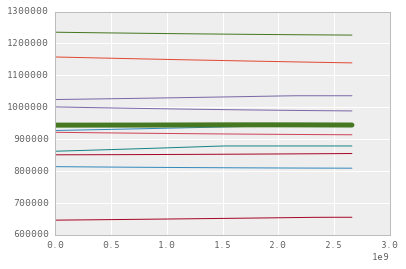

In [230]:
plt.plot(box_cox_model_lasso.alphas_, box_cox_model_lasso.mse_path_);
plt.plot(box_cox_model_lasso.alphas_, box_cox_model_lasso.mse_path_.mean(1), lw=5)

In [235]:
model = sm.OLS(box_cox_y_train, box_cox_X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        box_cox_ratings   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     1.917
Date:                Mon, 19 Sep 2016   Prob (F-statistic):            0.00297
Time:                        21:07:41   Log-Likelihood:                -5123.7
No. Observations:                 621   AIC:                         1.031e+04
Df Residuals:                     591   BIC:                         1.044e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                    2050.3416    326.649      6.277      0.000      1408.807  2691.876
day_released[T.Monday]        379.9944    681.494      0.558      0.577      -958.450  1718.439
day_released[T.Saturday]      179.0122    565.681      0.316      0.752      -931.978  1290.003
day_released[T.Sunday]        -14.8888    963.369     -0.015      0.988     -1906.932  1877.154
day_released[T.Thursday]     -194.2141    204.493     -0.950      0.343      -595.836   207.408
day_released[T.Tuesday]     -1.398e-07   4.12e-07     -0.339      0.734     -9.49e-07  6.69e-07
day_released[T.Wednesday]    -171.5240    134.330     -1.277      0.202      -435.347    92.299
genre[T.Adventure]            452.5376    195.052      2.320      0.021        69.458   835.617
genre[T.Animation]            403.3263    215.236      1.874      0.061       -19.395   826.048
genre[T.Biography]            453.3434    172.463      2.629      0.009       114.629   792.058
genre[T.Comedy]                96.3374    145.406      0.663      0.508      -189.238   381.912
genre[T.Crime]                233.4233    172.923      1.350      0.178      -106.196   573.043
genre[T.Documentary]         1034.1234    448.395      2.306      0.021       153.483  1914.764
genre[T.Drama]                239.0619    143.530      1.666      0.096       -42.829   520.952
genre[T.Fantasy]             -355.3833    564.582     -0.629      0.529     -1464.215   753.449
genre[T.Horror]              -168.4048    361.909     -0.465      0.642      -879.189   542.379
genre[T.Mystery]              897.2021    568.403      1.578      0.115      -219.134  2013.538
month_released[T.August]       -9.1587    191.400     -0.048      0.962      -385.067   366.749
month_released[T.December]   -153.2119    208.408     -0.735      0.463      -562.523   256.099
month_released[T.February]   -221.4095    239.131     -0.926      0.355      -691.059   248.240
month_released[T.January]     217.2164    201.400      1.079      0.281      -178.331   612.763
month_released[T.July]         11.8314    199.003      0.059      0.953      -379.008   402.671
month_released[T.June]        -36.6958    188.448     -0.195      0.846      -406.805   333.414
month_released[T.March]      -371.0144    197.897     -1.875      0.061      -759.681    17.652
month_released[T.May]        -218.3538    198.363     -1.101      0.271      -607.935   171.227
month_released[T.November]    108.9762    193.884      0.562      0.574      -271.810   489.762
month_released[T.October]    -286.7504    182.793     -1.569      0.117      -645.754    72.253
month_released[T.September]  -334.9018    192.447     -1.740      0.082      -712.865    43.061
runtime_minutes                 4.1956      2.530      1.658      0.098        -0.774     9.165
budget     

# Feature Selection

### Linear Regression

['Intercept', 'genre[T.Crime]', 'month_released[T.December]', 'genre[T.Adventure]', 'day_released[T.Monday]', 'genre[T.Mystery]', 'genre[T.Drama]', 'genre[T.Fantasy]', 'day_released[T.Wednesday]', 'month_released[T.February]', 'day_released[T.Thursday]', 'genre[T.Biography]', 'month_released[T.January]', 'month_released[T.March]', 'month_released[T.October]', 'month_released[T.June]', 'budget', 'genre[T.Animation]', 'month_released[T.September]', 'genre[T.Comedy]', 'runtime_minutes', 'genre[T.Horror]', 'day_released[T.Saturday]', 'genre[T.Documentary]', 'month_released[T.July]', 'day_released[T.Tuesday]', 'month_released[T.May]', 'month_released[T.August]', 'day_released[T.Sunday]', 'usa_dummy', 'month_released[T.November]']


Best Features:
['Intercept', 'genre[T.Adventure]', 'genre[T.Mystery]', 'genre[T.Drama]', 'genre[T.Fantasy]', 'genre[T.Biography]', 'month_released[T.January]']


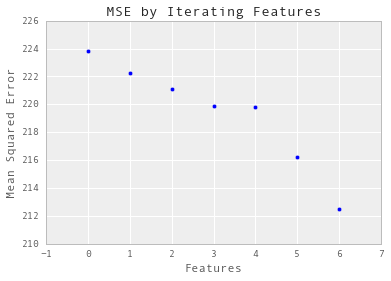

In [210]:
features = []
train_score=[]
feature_iter_test_score =[]
best_features = []
mean_score_test = 1e20

lst_ = [i for i in X.columns if not i =='Intercept']
shuffle(lst_)
lst_.insert(0, "Intercept")
print lst_

for i in lst_:
    features.append(i)
    df_new = box_cox_X[features]
    x_train, x_test, y_train, y_test = cross_validation.train_test_split(df_new,y,test_size=0.2,random_state=123)
    reg = linear_model.LinearRegression()

    reg.fit(x_train, y_train)
    score_train = metrics.mean_squared_error(y_train, reg.predict(x_train))
    score_test = metrics.mean_squared_error(y_test, reg.predict(x_test))
    train_score.append(score_train)

    if mean_score_test > score_test:
        feature_iter_test_score.append(score_test)
        mean_score_test = score_test
        best_features.append(i)
print ''
print ''
print 'Best Features:'
print best_features
plt.scatter(y = feature_iter_test_score, x = range(len(feature_iter_test_score)))
plt.xlabel('Features')
plt.ylabel('Mean Squared Error')
plt.title('MSE by Iterating Features')

### Lasso Regularization

In [219]:
features = []
train_score=[]
feature_iter_test_score =[]
best_features = []
mean_score_test = 1e20

lst_ = [i for i in X.columns if not i =='Intercept']
shuffle(lst_)
lst_.insert(0, "Intercept")
print lst_

for i in lst_:
    features.append(i)
    df_new = box_cox_X[features]
    x_train, x_test, y_train, y_test = cross_validation.train_test_split(df_new,y,test_size=0.2,random_state=1223)
    model_lasso = sklearn.linear_model.LassoCV(eps=0.001, n_alphas=100, cv=10).fit(x_train, sklearn.utils.column_or_1d(y_train))
    score_train = metrics.mean_squared_error(y_train, model_lasso.predict(x_train))
    score_test = metrics.mean_squared_error(y_test, model_lasso.predict(x_test))
    train_score.append(score_train)

    if mean_score_test > score_test:
        feature_iter_test_score.append(score_test)
        mean_score_test = score_test
        best_features.append(i)

['Intercept', 'genre[T.Biography]', 'month_released[T.June]', 'day_released[T.Saturday]', 'month_released[T.February]', 'genre[T.Comedy]', 'month_released[T.September]', 'genre[T.Documentary]', 'day_released[T.Thursday]', 'genre[T.Adventure]', 'genre[T.Crime]', 'month_released[T.March]', 'month_released[T.January]', 'genre[T.Horror]', 'budget', 'genre[T.Drama]', 'genre[T.Mystery]', 'day_released[T.Wednesday]', 'month_released[T.August]', 'month_released[T.December]', 'day_released[T.Sunday]', 'day_released[T.Monday]', 'month_released[T.November]', 'month_released[T.July]', 'genre[T.Animation]', 'day_released[T.Tuesday]', 'runtime_minutes', 'usa_dummy', 'month_released[T.October]', 'genre[T.Fantasy]', 'month_released[T.May]']


['Intercept', 'genre[T.Biography]', 'month_released[T.June]', 'month_released[T.February]', 'genre[T.Comedy]', 'month_released[T.September]', 'genre[T.Adventure]', 'genre[T.Crime]', 'month_released[T.January]']


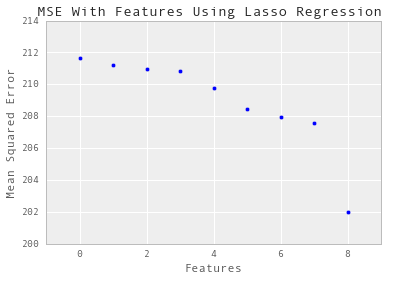

In [221]:
print best_features
plt.scatter(y = feature_iter_test_score, x = range(len(feature_iter_test_score)))
plt.xlabel('Features')
plt.ylabel('Mean Squared Error')
plt.title('MSE With Features Using Lasso Regression ')

In [226]:
bio = ['genre[T.Biography]',
       'genre[T.Drama]', 
       'genre[T.Mystery]', 
       'month_released[T.January]',
       'month_released[T.October]']

box_cox_model_lasso = sklearn.linear_model.LassoCV(eps=0.001, n_alphas=100, cv=10).fit(box_cox_X_train[bio], sklearn.utils.column_or_1d(box_cox_y_train))

training_error = sklearn.metrics.mean_squared_error(box_cox_y_train, box_cox_model_lasso.predict(box_cox_X_train[bio]))
test_error = sklearn.metrics.mean_squared_error(box_cox_y_test, box_cox_model_lasso.predict(box_cox_X_test[bio]))
#model_lasso1.predict(x_test,y_test)
print'Training error: %r' %training_error
print'Test Error: %r' %test_error
print '--------'
print('alpha=', box_cox_model_lasso.alpha_)
print '--------'
print 'Gain: %r' %((box_cox_baseline - test_error)/box_cox_baseline)[0]
print '--------'


Training error: 908733.87031786353
Test Error: 857379.2981939452
--------
('alpha=', 0.078913381577761607)
--------
Gain: 0.073701750040369704
--------


In [227]:

reg = linear_model.LinearRegression()

reg.fit(box_cox_X_train[bio], box_cox_y_train)

training_error = sklearn.metrics.mean_squared_error(box_cox_y_train, reg.predict(box_cox_X_train[bio]))
print 'Training Error: %r' %training_error
test_error = sklearn.metrics.mean_squared_error(box_cox_y_test, reg.predict(box_cox_X_test[bio]))
print 'Test Error: %r' %test_error
print 'Gain: %r' %((box_cox_baseline - test_error)/box_cox_baseline)[0]

Training Error: 908732.2906000386
Test Error: 857355.29204917967
Gain: 0.073727685877555682
